In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

2023-11-27 20:11:09.015081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 20:11:18.933863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-27 20:11:18.934091: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-27 20:11:18.934105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [4]:
import os

df = pd.read_csv("ml.csv")

In [47]:
# part of this section code is taught by Chatgpt
df = df.sort_values(by=['subreddit', 'year', 'month'])
df_sub = df[df["subreddit"] == "FinalFantasy"]
def model_predict(data,name):



    df_pivot = data.pivot_table(index=['year', 'month'], columns='subreddit', values='post_count', aggfunc='sum', fill_value=0)


    df_pivot.index = pd.to_datetime(df_pivot.index.map(lambda x: '-'.join(map(str, x))))


    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_pivot), index=df_pivot.index)

    sequence_length = 3 

    X, y = [], []
    for i in range(len(df_scaled) - sequence_length):
        X.append(df_scaled.iloc[i:i+sequence_length].values)
        y.append(df_scaled.iloc[i+sequence_length].values)

    X = np.array(X)
    y = np.array(y)
    split = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

    model = Sequential()
    model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1, activation='linear'))

# Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')  # Mean Squared Error is a common loss function for regression problems

    model.fit(X_train, y_train, epochs=50, batch_size=32)

    loss = model.evaluate(X_test, y_test)
 

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform the predictions and actual values to the original scale
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    predictions = []

    last_months = df_scaled.tail(sequence_length).values


    next_months_index = pd.date_range(df_scaled.index[-1], periods=7, freq='MS')[1:]

    for i in range(6):  
 
        last_months_reshaped = last_months.reshape((1, sequence_length, df_scaled.shape[1]))

        predicted_scaled = model.predict(last_months_reshaped)

        predicted = scaler.inverse_transform(predicted_scaled)

   
        predictions.append(predicted[0])

    
        last_months = np.vstack([last_months[1:], predicted_scaled])

    predictions = np.array(predictions)

    predicted_df = pd.DataFrame(predictions, index=next_months_index, columns=df_pivot.columns)
    last_row_df_pivot = df_pivot.iloc[-1:]

    predicted_df = pd.concat([predicted_df, last_row_df_pivot])
    
    predicted_df = predicted_df.sort_index()
    plt.figure(figsize=(12, 6))
    plt.plot(df_pivot.index, df_pivot[df_pivot.columns], label='Original Data', marker='o')

# Plot the predicted data for the next three months
    plt.plot(predicted_df.index, predicted_df[df_pivot.columns], label='Predicted Data', marker='o')

    plt.title('Original vs Predicted GTA Posts Count')
    plt.xlabel('Date')
    plt.ylabel('Posts Count')
    plt.legend()
    plt.show()


Epoch 1/50
1/1 [==============================] - 1s 806ms/step - loss: 0.1506
Epoch 2/50
1/1 [==============================] - 0s 5ms/step - loss: 0.1353
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1220
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1104
Epoch 5/50
1/1 [==============================] - 0s 5ms/step - loss: 0.1004
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0921
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.0852
Epoch 8/50
1/1 [==============================] - 0s 3ms/step 

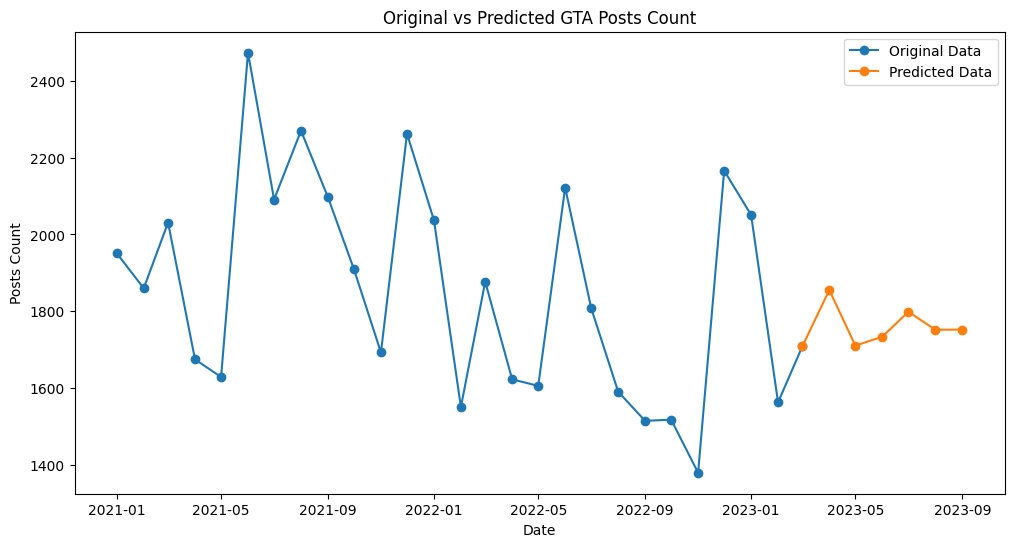

In [48]:
model_predict(df_sub,"FinalFantasy")

Epoch 1/50
1/1 [==============================] - 1s 787ms/step - loss: 0.1340
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1227
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1125
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.1032
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0950
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0880
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.0819
Epoch 8/50
1/1 [==============================] - 0s 3ms/step 

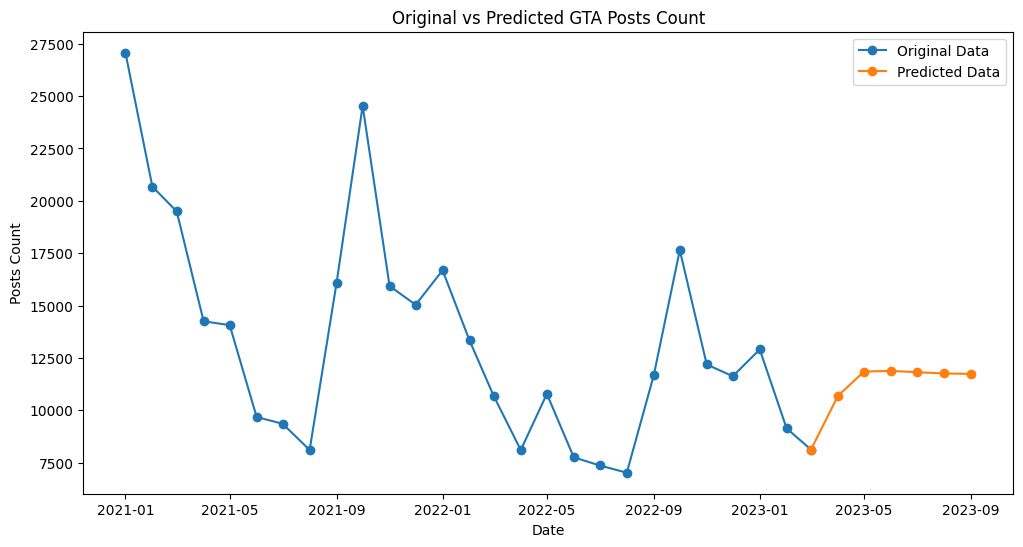

In [49]:
df_sub = df[df["subreddit"] == "FIFA"]
model_predict(df_sub,"FIFA")

In [50]:
df['subreddit'].unique()

array(['CallOfDuty', 'FIFA', 'FinalFantasy', 'GTA', 'SuperMario',
       'Tetris', 'assassinscreed', 'legostarwars', 'pokemon', 'thesims'],
      dtype=object)

Epoch 1/50
1/1 [==============================] - 1s 830ms/step - loss: 0.1819
Epoch 2/50
1/1 [==============================] - 0s 5ms/step - loss: 0.1709
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1606
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1510
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1421
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1337
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1258
Epoch 8/50
1/1 [==============================] - 0s 4ms/step 

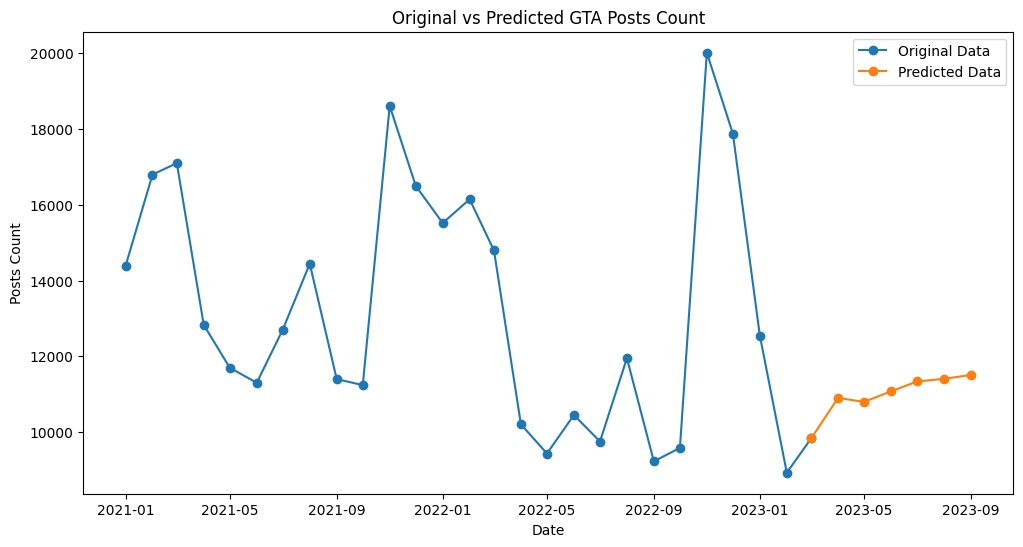

In [51]:
df_sub = df[df["subreddit"] == "pokemon"]
model_predict(df_sub,"FIFA")